# Transformer - 심화 과제 (MHA / 감정 분석 모델 구현)
```
- IMDb 데이터셋
- Self-Attention => MHA 확장
  - layer normalization
  - dropout
  - residual connection
- Transformer encoder의 완전한 형태 구현
```

In [ ]:
!pip install datasets sacremoses

In [ ]:
import torch
from torch import nn
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
import tokenizers
from torch.nn.utils.rnn import pad_sequence
from math import sqrt

# ds = load_dataset("stanfordnlp/imdb")
train_ds = load_dataset("stanfordnlp/imdb", split="train[:5%]")
test_ds = load_dataset("stanfordnlp/imdb", split="test[:5%]")

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

**BERT Tokenizer Fnc**   
- to_tensor 값에 따라 PyTorch Tensor type 혹은 Numpy 배열로 리턴한다
- `collate_fn`에서 `pad_sequence`를 통해 동적 padding 수행하기에 `padding=True` 제외
  - 데이터셋 중 가장 긴 문장길이가 200이라고하면, max_len으로 지정한 400으로 모두 padding 처리하는 것은 비효율
  - 200으로 동적 padding을 수행해줌

In [3]:
def tokenizer_bert(text, max_length, to_tensor=False):

  return tokenizer(text, truncation=True, max_length=max_length, return_tensors= 'pt' if to_tensor else None)

## `collate_fn(batch)`
- PyTorch DataLoader에서 batch 단위로 데이터를 불러옴
- 불러온 각 데이터를 어떻게 하나의 batch로 묶을지 정의하는 함수
``` python
DataLoader(dataset, batch_size=64, collate_fn=collate_fn)
```

**방향성**   
- 보다 명확히 유효 토큰을 필터링하여 리턴한다

**batch**   
- 길이: 64 `batch_size`지정 값
- 각 원소는 dataset[i]
``` python
  {'text': ...., 'label':....} 👉🏻 상단에 print 부분 참조

  # 즉 아래와 같은 형태
  batch = [dict(text='sep1,,', label=0), dict(text='sep2,,', label=1), ...]
```

<br>

**`torch.nn.utils.rnn.pad_sequence`**   
- 여러 길이의 sequence를 하나의 tensor로 묶기위해 padding을 자동으로 추가
- 같은 크기로 맞춰줌
  - Model에 batch로 넣기 위해 꼭 필요함
``` python
    texts = [
      torch.tensor([101, 2009, 2001]),
      torch.tensor([101, 1996]),
      torch.tensor([101, 1996, 2190, 3185])
    ]

    pad_sequence(texts, batch_first=True, padding_value=0)

    👉🏻 tensor([
      [101, 2009, 2001,    0],
      [101, 1996,    0,    0],
      [101, 1996, 2190, 3185]
    ])
```

In [4]:
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []

  # ignore token을 지정
  # ignore_policy를 제외함
  IGNORE_TOKENS = {
      tokenizer.sep_token_id,
      tokenizer.pad_token_id,
      # list comprehension
      *[tokenizer.convert_tokens_to_ids(ignore_policy) for ignore_policy in ['.', ',', '?', '!', ';']]
  }

  for row in batch:

    # input_ids: BERT Tokenization, input_ids 추출
    ids = tokenizer_bert(row['text'], max_len).input_ids

    # 유효 label 찾기: 뒤에서 부터 하나씩 체크
    for i in range(len(ids) - 1, -1, -1):
      token_id = ids[i]
      if token_id not in IGNORE_TOKENS:
        label_id = token_id
        label_pos = i
        break
      # 유효 토큰이 없는 경우 넘어감
      else:
        continue

    # 입력 값에서 label 제외
    # 유효 text만 추출
    ids = ids[:label_pos]
    if len(ids) < 2:
      continue

    texts.append(torch.LongTensor(ids))
    labels.append(label_id)

  # 유효 text가 하나도 없으면 빈 텐서 리턴
  # 빈 텐서를 pad_sequence 처리하면 에러 발생
  if not texts:
    return torch.empty(0), torch.empty(0)

  # policy에 맞는 유효 토큰을 추출한 후
  # Model에 넣기 전 전처리
  # tokenizer에서 진행하지 않은 padding 작업을 수행하여
  # 정사각 tensor로 변환
  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

### Multi-Head-Attention
- Self-Attention을 여러 개의 head로 **병렬 실행**해서 서로 다른 시각으로 관계성을 이해하게 해줌
  - 각 head는 입력을 다르게 쪼개어 다양한 관계에 집중
  - 마지막에 **head별 attention 결과를 concat**

**`D` / `D'`**
- `D`: d_model, 전체 embedding 차원
- `D'`: 각 head가 가져가는 **부분 차원**
  ``` python
  D' = d_model // n_heads
  ```
<br>

**summary**

```
입력 * (B, S, D)
  ↓
W_q, W_k, W_v projection
  ↓
reshape → (B, H, S, D')
  ↓
dot-product attention (QKᵀ / √D')
  ↓
softmax → attention weights
  ↓
attention * V
  ↓
concat heads → (B, S, D)
  ↓
Linear projection → 최종 출력

```

In [5]:
class MultiHeadAttention(nn.Module):
  def __init__(self, input_dim, d_model, n_heads):
    super().__init__()

    # D(d_model)가 H(n_heads)로 나눠 떨어지는 값이라는 제약 조건
    # assert: 이 조건은 코드 작성자인 내가 보증하며, 이 조건이 거짓이면 AssertionError를 발생시키도록 함
    assert d_model % n_heads == 0, '모델의 차원수가 head의 수의 배수가 아닙니다'

    self.d_model = d_model
    self.n_heads = n_heads
    self.d_head = d_model // n_heads # D'

    # Q, K, V projection layer
    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)

    # 여러 head를 합친 결과를 하나의 projection으로
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    B, S, _ = x.shape # Batch, Seq_len / 배치 크기, 시퀀스 길이만 가져오기

    # Q, K, V 만든 후, (B, S, H, D)로 reshape, transpose(1, 2)로 (B, H, S, D) => 여기서는 view()를 사용해서 shape을 바꿈
    # (B, S, D) => (B, S, H, D) => (B, H, S, D')
    # batch마다 H개의 attention head를 갖게
    q = self.wq(x).view(B, S, self.n_heads, self.d_head).transpose(1, 2) # (B, H, S, D')
    k = self.wk(x).view(B, S, self.n_heads, self.d_head).transpose(1, 2)
    v = self.wv(x).view(B, S, self.n_heads, self.d_head).transpose(1, 2)

    # 각 head마다 Q * K transpose 계산 -> 단어들 간의 유사도 데이터
    # 내적 값이 너무 커지는 경우를 방지하기 위한 스케일링: sqrt(D')로 나눔
    score = torch.matmul(q, k.transpose(-1, -2)) / sqrt(self.d_head)

    # Mask 적용
    # padding token 무시하도록 선언
    if mask is not None:
      # unsqueeze: 해당 위치에 차원을 1의 크기로 추가하는 함수 <-> squeeze()
      mask = mask.unsqueeze(1)
      score = score.masked_fill(mask == 1, -1e9)

    # softmax 취하고 v 값 곱해주기
    attention = self.softmax(score) # (B, H, S, S)
    context = torch.matmul(attention, v) # (B, H, S, D')

    # concat heads
    # transpose 처리한 텐서는 메모리 상 비연속 => contiguous 처리 후 view 처리
    context = context.transpose(1, 2).contiguous().view(B, S, self.d_model) # (B, S, D)

    output = self.dense(context)

    return output

## Self-attention

In [6]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result

### Transformer Layer
- Multi-Head-Attention
- Residual Connection
- Dropout
- Layer Normalization

```
x1 = MHA(x, mask)
x1 = Dropout(x1)
x1 = LayerNorm(x1 + x)

x2 = FFN(x1)
x2 = Dropout(x2)
x2 = LayerNorm(x2 + x1)
```

In [7]:
class TransformerLayer(nn.Module):
  def __init__(self, d_model, n_heads, d_ff, dropout=0.1): # dropout 0.1 설정
    super().__init__()

    # MHA
    self.mha = MultiHeadAttention(d_model, d_model, n_heads)
    # Feed Forward
    self.ffn = nn.Sequential(
        nn.Linear(d_model, d_ff),
        nn.ReLU(),
        nn.Linear(d_ff, d_model)
    )

    # Layer Norm
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)

    # Dropout
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask):
    # MHA + Residual + LayerNorm
    # 처음 들어온 값에 대해 MHA
    x1 = self.mha(x, mask)

    # MHA 통과한 값 Dropout
    x1 = self.dropout(x1)

    # LayerNorm
    x1 = self.norm1(x1 + x) # f(x) = x + g(x): Residual Connection 처리

    # FeedForward + Residual + LayerNorm
    # MHA 거쳐온 결과값을 FeedForward
    x2 = self.ffn(x1)

    # Dropout
    x2 = self.dropout(x2)

    # LayerNorm
    x2 = self.norm1(x1 + x2)


    return x

## Positional encoding

$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

In [8]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


### WordPredictor (Transformer Layer + Positional Encoding)

**✅5 Layers 4 Heads 구축**   
- `TransformerLayer` 5개 쌓기
- 각 레이어에서 MHA 4-head 설정

``` python
d_model:  128
n_layers: 5
n_heads:  4
dropout:  0.1
d_ff      512
```

<br>

**Binary Classification => Last Word Prediction 변경**   
- output 차원을 1 => vocab_size로 변경
```
👉🏻 예측할 class의 수가 vocab_size 만큼 있기 때문에 변경한다
```
<br>

**Asis**   
- 긍정 or 부정
- 1개의 logit으로 표현 (sigmoid를 통한 확률 추출)
- 총 class: 2개 (0, 1)
``` python
# 이진 분류 0 or 1 class
self.classification = nn.Linear(d_model, 1)
```
<br>

**Tobe**
- BERT vocab 내 모든 단어 중 **가장 가능성이 높은 단어를 예측한다**
- 총 class: `vocab_size`개 (BERT에서는 30,522개)
``` python
self.classification = nn.Linear(d_model, vocab_size)
```   

<br>

**forward**   
`x`: collate_fn에서 pad_sequence 처리되어 동적 padding 처리된 input tensor (text)   
``` python
x = [
  [101, 2023, 2003, 1037, 2742, 102, 0, 0, 0],  # padding 포함된 문장
  [101, 2057, 2293, 2009, 102, 0, 0, 0, 0]
]

# x.shape = (B, S) # B: 배치 크기, S: 최대 시퀀스 길이

# 101 = [CLS]
# 102 = [SEP]
# 0 = [PAD] (tokenizer.pad_token_id)
```
- `mask`
  - Transformer는 Self-Attention을 사용하기에, 모든 토큰이 서로를 참조한다
  - 하지만, `padding`부분은 **무효한 공간이기 때문에** 무시해야한다 => `mask`를 만들어서 padding 부분은 attention score 계산에서 제외시킨다
  ``` python
    # padding된 위치만 골라낸다
    # (B, S)
    mask = (x == tokenizer.pad_token_id)
    
    # (B, S, S) => (B, 1, S)
    # 추후 attention score 계산을 위한 브로드캐스팅
    mask = mask[:, None, :]  # shape: (B, 1, S)
  ```

In [9]:
class WordPredictor(nn.Module):
  def __init__(self, vocab_size, d_model=128, n_layers=5, d_ff=512, n_heads=4, dropout=0.1):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(512, d_model), requires_grad=False)

    # 5 layers 4 heads 구조 잡기
    self.layers = nn.ModuleList([TransformerLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])

    # 사용 Model의 vocab에 있는 모든 단어를 참고하여 가장 가능성이 높은 단어를 뽑아내야한다
    self.prediction = nn.Linear(d_model, vocab_size)

  # x: collate_fn에서 return한 text => pad_sequence를 통해 padding이 적용된 상태
  def forward(self, input_ids):
    # 무효한 padding token 부분 제외
    mask = (input_ids == tokenizer.pad_token_id)
    # broadcasting
    mask = mask[:, None, :]
    # (B, S)[1]
    seq_len = input_ids.shape[1]

    # x에 대해 d_model 차원의 벡터로 변환
    x = self.embedding(input_ids)
    # 벡터값이 너무 작아지는 걸 방지하기 위한 scaling
    # BERT/Transformer 논문에서 embedding 벡터의 분산이 1이 되도록 하자는 의도라고 함
    x = x * sqrt(self.d_model)
    # positional encoding을 통한 위치 데이터 삽입
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    # mask 처리되지 않은 실제 입력 시퀀스만 모은 후,
    # 마지막 유효 토큰의 index를 찾아낸다
    # ex> [101, 123, 234, 567, 0, 0] / pad: 2개 / input_length(마지막 유효 토큰 index): 4 - 1 = 3
    # (B,)
    input_length = (input_ids != tokenizer.pad_token_id).sum(dim=1) -1

    # 3차원 텐서에서 마지막 행 마지막 열의 출력값을 꺼낸다
    # 배치 내 각 문장마다 마지막 토큰의 위치를 동적으로 뽑는다
    # torch.arange는 numpy.arrange와 비슷하다
    # (B, D)
    last_output = x[torch.arange(x.size(0)), input_length]

    x = self.prediction(last_output)

    return x

# 차원 고정값이므로, vocab_size만 넘긴다
model = WordPredictor(len(tokenizer))

## 학습

### BCEWithLogitsLoss vs CrossEntropyLoss
|항목	|BCEWithLogitsLoss|	CrossEntropyLoss|
|:---|:---|:---|
|목적	|이진 분류|	다중 클래스 분류 (ex. MNIST, 단어 예측 등)
|출력	|(B, 1) 또는 (B,)|	(B, C) (C는 클래스 개수)
|정답	|float/int (0 or 1)|	int (0 ~ C-1 중 하나)
|내부 처리	|sigmoid + binary cross entropy|	softmax + log + negative log likelihood


In [10]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

**Accuracy fnc**   
`평가 모드 적용`
- model.eval()
- with torch.no_grad()



In [11]:
import numpy as np
import matplotlib.pyplot as plt

def accuracy(model, dataloader):
  model.eval()
  correct = total = 0

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs) # (B, vocab_size) / vocab 내 모든 단어 참고
      preds = torch.argmax(preds, dim=-1) # (B,) / 특정 단어 예측

      correct += (preds == labels).sum().item()
      total += labels.size(0)

  return correct / total

**시각화 함수**

In [12]:
import matplotlib.pyplot as plt

def plot_training(history):
    epochs = list(range(1, len(history["train_loss"]) + 1))

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["test_acc"], label="Test Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [13]:
n_epochs = 50

# 학습 기록용
history = {
    "train_loss": [],
    "train_acc": [],
    "test_acc": []
}

for epoch in range(n_epochs):
  torch.cuda.empty_cache()

  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    optimizer.zero_grad()

    preds = model(inputs) # (B, vocab_size)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # print(f'실제로 랜덤하게 나오는지 정답 뽑아보기\n{tokenizer.convert_ids_to_tokens(labels[:10].tolist())}')

  print(f"Epoch {epoch + 1:3d} | Train Loss: {total_loss}")

  train_acc = accuracy(model, train_loader)
  test_acc = accuracy(model, test_loader)

  print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

  # 기록 저장
  history["train_loss"].append(total_loss)
  history["train_acc"].append(train_acc)
  history["test_acc"].append(test_acc)

Epoch   1 | Train Loss: 458.3153610229492
=========> Train acc: 0.043 | Test acc: 0.015
Epoch   2 | Train Loss: 275.6476135253906
=========> Train acc: 0.123 | Test acc: 0.059
Epoch   3 | Train Loss: 183.58909130096436
=========> Train acc: 0.205 | Test acc: 0.085
Epoch   4 | Train Loss: 127.16447830200195
=========> Train acc: 0.314 | Test acc: 0.098
Epoch   5 | Train Loss: 89.79195642471313
=========> Train acc: 0.418 | Test acc: 0.098
Epoch   6 | Train Loss: 70.2613639831543
=========> Train acc: 0.462 | Test acc: 0.110
Epoch   7 | Train Loss: 58.35688519477844
=========> Train acc: 0.492 | Test acc: 0.114
Epoch   8 | Train Loss: 52.58213269710541
=========> Train acc: 0.499 | Test acc: 0.114
Epoch   9 | Train Loss: 48.523338317871094
=========> Train acc: 0.509 | Test acc: 0.114
Epoch  10 | Train Loss: 45.16714537143707
=========> Train acc: 0.526 | Test acc: 0.124
Epoch  11 | Train Loss: 42.70384240150452
=========> Train acc: 0.536 | Test acc: 0.117
Epoch  12 | Train Loss: 40.572

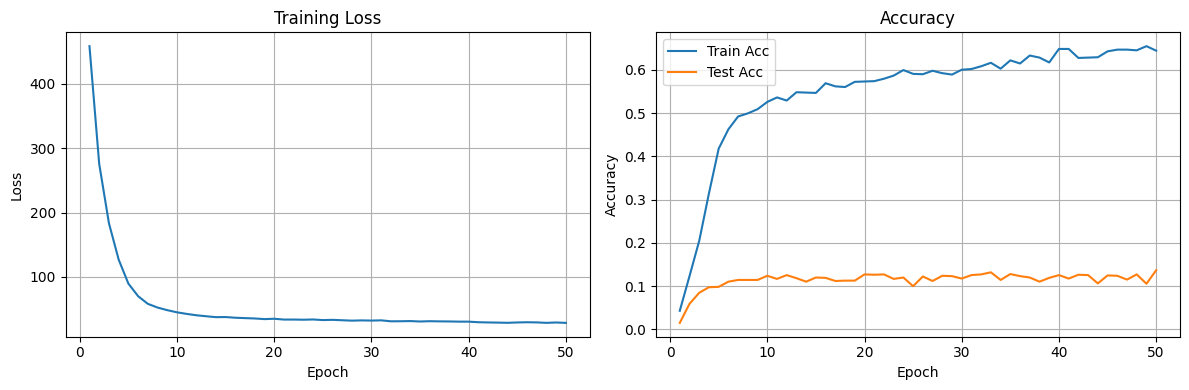

In [14]:
plot_training(history)